Vi har sett ett enkelt exempel på klassifikation, i exemplet med färger som torkar:

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

df = pd.read_csv("../data/paint.csv")

df.head()

,Relative humidity (%),type,Evaporation (% wt)
0,35.3,1,11.2
1,29.6,1,11.0
2,31.0,1,12.6
3,58.0,1,8.3
4,62.0,1,10.1


Kolumnen "type" anger två _klasser_ av data, där 0 och 1 indikerar vilken av de två som datan tillhör. Detta är ett exempel på s.k "labelled data" och att sätta etiketter på data är en favoritsysselsättning hos praktikanter (eller inte). Det är tyvärr ett måste för s.k. "supervised learing" vilket är det vi sysslar med här. Vi måste alltså ha testfall där vi vet utfallet för att kunna träna systemet -- dvs göra regressioner.

Det är även ett exempel på "dummy encoding". En annan, nästan ekvivalent kodning är "one-hot coding". Det skulle se ut så här:

| Relative humidity | TypeA | TypeB | Evaporation |
| --- | --- | --- | --- |
| 35.3 | 1 | 0 | 11.2 |
...

Då får det inte förekomma en rad där alla indikatorvariablerna är 0 -- det är något sorts basfall som vi inte har definierat i detta exempel. "One-hot" fungerar bättre på kvalitativ data som beskriver icke-exklusiva egenskaper där 0 indikerar avsaknad av egenskapen, snarare än hårda avgränsningar. "Dummy encoding" fungerar bäst med ömsesidigt exklusiva klasser. I slutändan måste vi tolka vad kodningen betyder; har vi flera regressionslinjer och därmed flera modeller? Vilka indikatorvariabler tillhör vilken modell i så fall?

Data row 10, False should be: 1.0 , distances: (3.725682895672335, 2.883061925068286)
Data row 6, False should be: 1.0 , distances: (3.977730290330465, 2.6690938852690254)


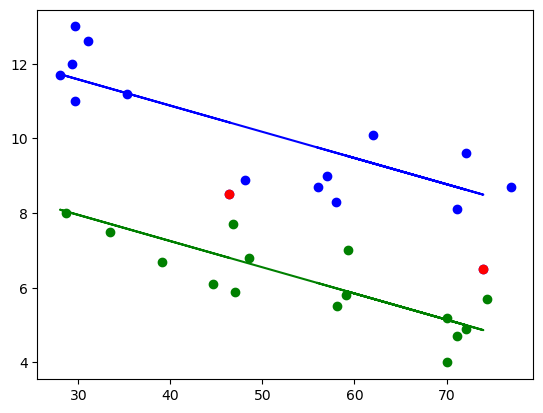

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X, Y = df.drop("Evaporation (% wt)", axis="columns"), df["Evaporation (% wt)"]


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=24)


model = LinearRegression()
model.fit(X_train, Y_train)

# Tolka kategorisk data -- i detta fall två separata linjer!
b = model.coef_
modA = np.append(model.intercept_ + b[1], b[0])
modB = np.append(model.intercept_, b[0])

# Uvärdera på test
Xr =  X_test.drop("type", axis="columns")
Xr.insert(0, "intercept", 1)
x = Xr["Relative humidity (%)"]

# Visa hela mängden med färgkodade datapunkter efter typ
splitA = df[df["type"] == 1]
splitB = df[df["type"] == 0]
splitA, splitB
X_A = splitA["Relative humidity (%)"]
X_B = splitB["Relative humidity (%)"]
Y_A = splitA["Evaporation (% wt)"]
Y_B = splitB["Evaporation (% wt)"]
plt.scatter(X_A, Y_A, c="blue")
plt.scatter(X_B, Y_B, c="green")

# plotta våra två regressionslinjer
plt.plot(x, Xr @ modA, "b")
plt.plot(x, Xr @ modB, "g")

# Gör linjär klassifiering
def classify(x, y):
    row_x = [1.0, x]
    ea_sq = np.square(y - (row_x @ modA))
    eb_sq = np.square(y - (row_x @ modB))
    return ea_sq < eb_sq

Y = Y_test
X = X_test["Relative humidity (%)"]
T = X_test["type"]
correct = True
for i, x in enumerate(X):
    if(T.iloc[i] != classify(x, Y.iloc[i])):
        plt.scatter(x, Y.iloc[i], c="red")
        row_x = [1.0, x]
        ea_sq = np.square(Y.iloc[i] - (row_x @ modA))
        eb_sq = np.square(Y.iloc[i] - (row_x @ modB))
        print(f"Data row {X_test.iloc[i].name}, {classify(x, Y.iloc[i])} should be: {X_test.iloc[i][1]} , distances: {ea_sq, eb_sq}")
        

De två felklassifierade punkterna ligger i närheten av mittpunkten mellan regressionslinjerna. De tillhör egentligen den övre linjen, men variansen är så stor att de överlappar med gränsen för den undre linjen.

Om vi tänker oss en funktion av avståndet som ger '1' för den övre och '0' för den undre linjen ser grafen ut något i stil med:
![image](../assets/heaviside_im1.jpg)

Om vi istället är intresserade av en direkt klassifikator behöver vi behandla datan annorlunda.  Vi försöker nu _förutsäga_ "type" direkt istället för att räkna på ett avstånd från vår förustsägelse av "Evaporation". Alltså skall "type" kolumnen nu vara vårt $Y$!

Utan att gå på djupet med den just nu så använder vi en _logistisk_ regression, vilket är ett historiskt namn som betyder "exponentiell". Särskilt försöker vi göra en fit mot en S-kurva (sigmoid) istället för steg-funktionen ovan.



Så här ser en sigmoid ut:

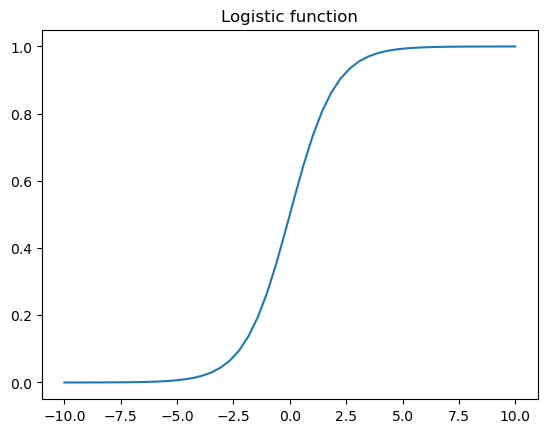

In [35]:
logistic_function = lambda x: np.exp(x)/(1+np.exp(x))

x = np.linspace(-10, 10)
plt.plot(x, logistic_function(x))
plt.title("Logistic function"); 

Det finns mängder av sådana kurvor, men den logistiska funktionen är ett populärt val:

\begin{equation*}
f(x) = \frac{L}{1+e^{-k(x-x_0)}}
\end{equation*}

vilket i vårt fall kan skrivas på en enklare form:


\begin{equation*}
f(x) = \frac{e^x}{1+e^{x}}
\end{equation*}

eller till och med:

\begin{equation*} 
p(X) = \frac{e^{\beta_0+\beta_1X}}{1+e^{\beta_0+\beta_1X}}
\end{equation*}

där $p(X) = P[Y|X]$ dvs sannolikheten är Y är sant givet värdena i X. Det är precis den sannolikheten vi söker! Härldeningen är inte helt enkelt, men det är alltså en normal matematisk härledning och inte något esoteriskt som bestämts experimentellt.

En logistisk regression använder inte OLS utan en Maximum Likelihood Estimator; i praktiken är det oftast någon sorts iterativ gradient descent, men det finns andra sätt att hitta en MLE. Vi behöver inte bry oss om detaljerna när vi använder sklearn, men vi återkommer till detta med lite mer teori framöver.

Notera att Y är mellan 0 och 1! Detta är en stor anledning att vi väljer denna funktion. Det måste förstås vara så då vi har att göra med sannolikheter.

Användningen följer ett mönster som nu borde börja bli bekant:

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV

# Note that now the categorical data is our Y
X, Y = df.drop("type", axis="columns"), df["type"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=24, test_size=0.3)
# We do need scaling! Try without and you will see much worse results.
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

#log_reg = LogisticRegression(penalty=None)
log_reg = LogisticRegressionCV(penalty='elasticnet', l1_ratios=np.linspace(0,1,10), solver="saga", max_iter=10000)
log_reg.fit(scaled_X_train, Y_train)

Y_hat = log_reg.predict_proba(scaled_X_test)
print(f"Probability of correct prediction:\n{(Y_test - Y_hat[:,0]).round(6).abs()}")
print(f"Concrete prediction correctness: \n{1 - (Y_test - log_reg.predict(scaled_X_test))}")

Probability of correct prediction:
10    0.517067
12    0.959046
24    0.958393
8     0.720212
6     0.278429
28    0.936678
21    0.987854
5     0.949518
20    0.945451
13    0.704159
Name: type, dtype: float64
Concrete prediction correctness: 
10    1
12    1
24    1
8     1
6     0
28    1
21    1
5     1
20    1
13    1
Name: type, dtype: int64


Notera att det på inget sätt är garanterat att logistisk regression är bättre än linjär i det här fallet. Vi kan stuva om lite i värdena så att den linjära versionen gör bättre ifrån sig än den logistiska. Det är i detta fall verkligen två linjärt separerade klasser. En fördel med den logistiska klassifikatorn är att vi får en idé om hur säker förutsägelsen är i och med predict_proba(). I allmänhet är det en god idé att välja modeller och tekniker som stödjer de tester och statistikor vi är intresserade av.